## Group proposal: Heart Disease Diagnostic Tool

In [3]:
library(rvest)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fi

### Introduction: 

### Preliminary exploratory data analysis: Reading and Wrangling the Data

In [4]:
set.seed(293)

dataset_test <- download.file(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
    "heart_disease.csv")

heart_data <- read_csv("heart_disease.csv", col_names = FALSE)


heart_data <- rename(heart_data, 
                     age =X1,
                     sex =X2,
                     cp =X3,
                     trestbps =X4,
                     chol = X5,
                     fbs =X6,
                     restecg=X7,
                     thalach=X8,
                     exang=X9,
                     oldpeak=X10,
                     slope=X11,
                     ca=X12,
                     thal=X13,
                     diagnosis=X14)

idx <- heart_data == "?"
is.na(heart_data) <- idx                                 #eliminates ? and replaces with NA

heart_data[] <- sapply(heart_data, as.numeric) #converts all the data to numeric

names = c('sex', 'cp', 'exang', 'slope', 'thal', 'diagnosis', "restecg", "ca", "fbs") #unsure if ca is a factor
heart_data[,names] <- lapply(heart_data[,names] , factor)

heart_data <- mutate(heart_data, diagnosis = ifelse(diagnosis == "1"|diagnosis == "2"|diagnosis == "3"|diagnosis == "4", "Positive", "Negative"))
heart_data <- mutate(heart_data, diagnosis = as.factor(diagnosis))          #changes the diagnosis values to strings

heart_data


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,Negative
67,1,4,160,286,0,2,108,1,1.5,2,3,3,Positive
67,1,4,120,229,0,2,129,1,2.6,2,2,7,Positive
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7,Positive
57,0,2,130,236,0,2,174,0,0.0,2,1,3,Positive
38,1,3,138,175,0,0,173,0,0.0,1,NA,3,Negative


### Splitting data into training and testing sets

In [5]:
heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)          #splits data
heart_train <- training(heart_split)
heart_test <- testing(heart_split) 

### Number of Positive and Negative diagnoses

In [6]:
count_train_summary <- group_by(heart_train, diagnosis) |>
    summarize(count=n())
count_train_summary

diagnosis,count
<fct>,<int>
Negative,123
Positive,104


### Average of numerical columns

In [7]:
stats_avg <- heart_train |>
    select(age, trestbps, chol, thalach, oldpeak, diagnosis) |>
    group_by(diagnosis) |>
    summarize(across(age:oldpeak, mean, na.rm = TRUE))

stats_avg

diagnosis,age,trestbps,chol,thalach,oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Negative,51.82114,128.3008,237.8862,158.9675,0.5699187
Positive,56.58654,132.1442,250.1635,139.1250,1.5788462


### Number of missing values in each column

In [8]:
heart_train |>
    summarise_all(funs(sum(is.na(.))))

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,3,0,0


### Visualizations of Predictor Variables

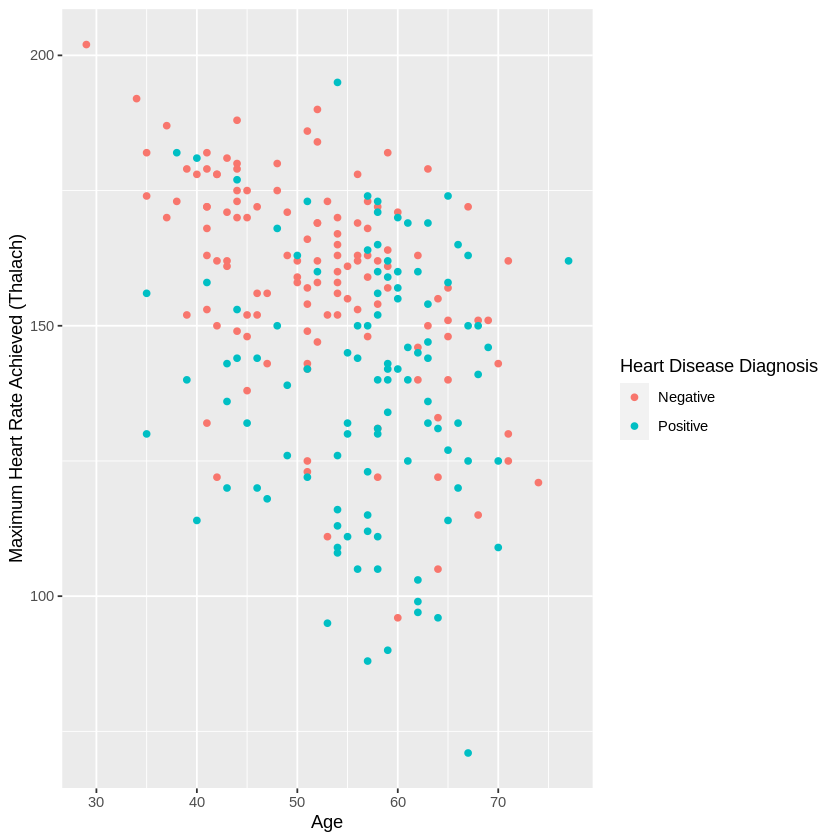

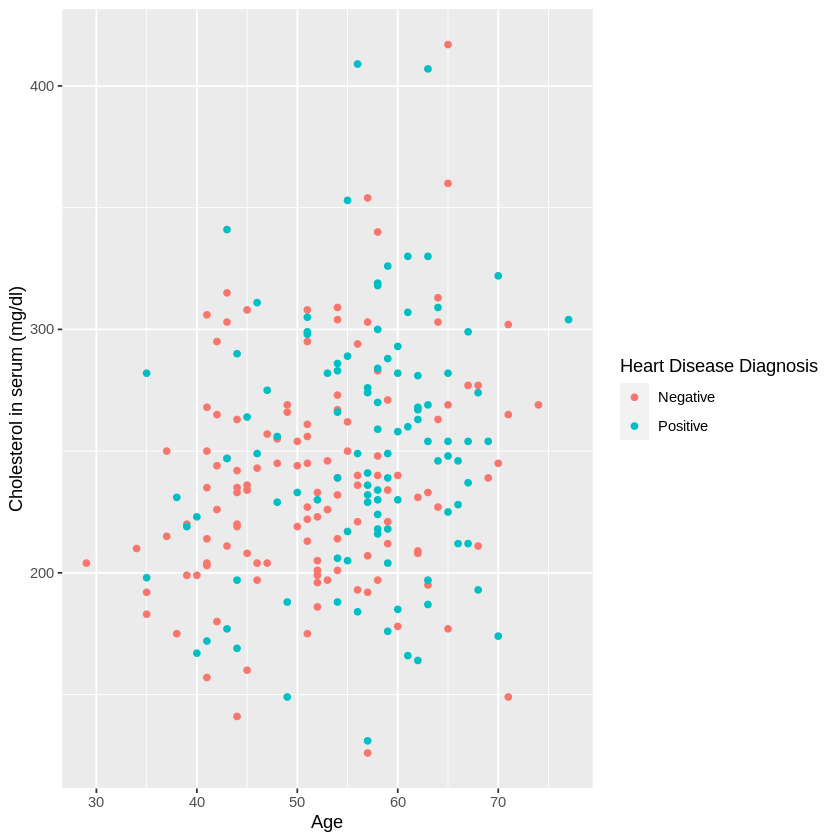

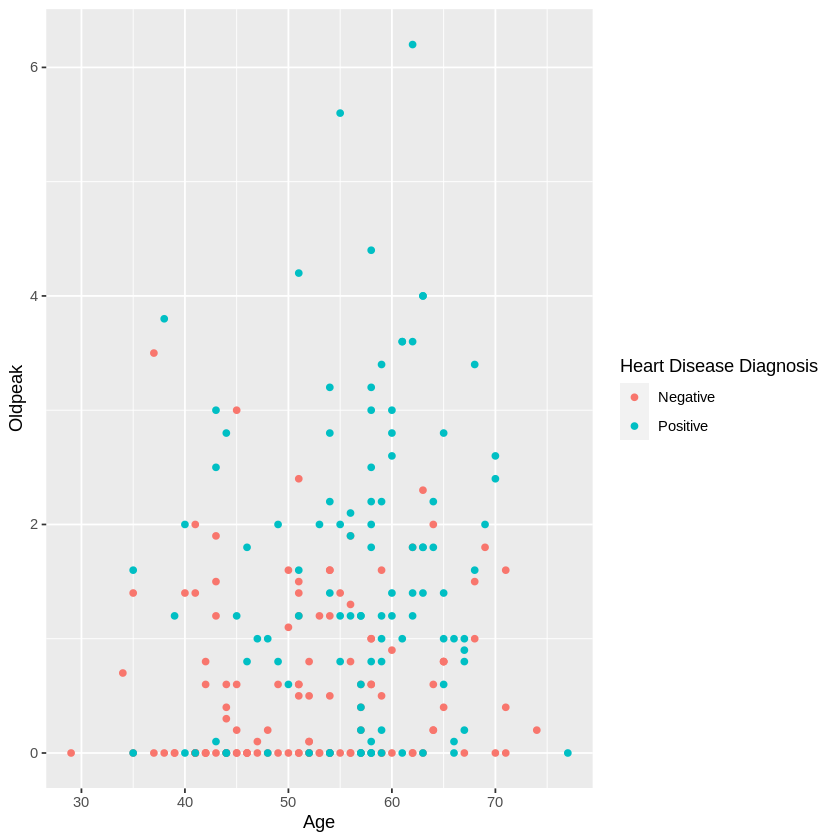

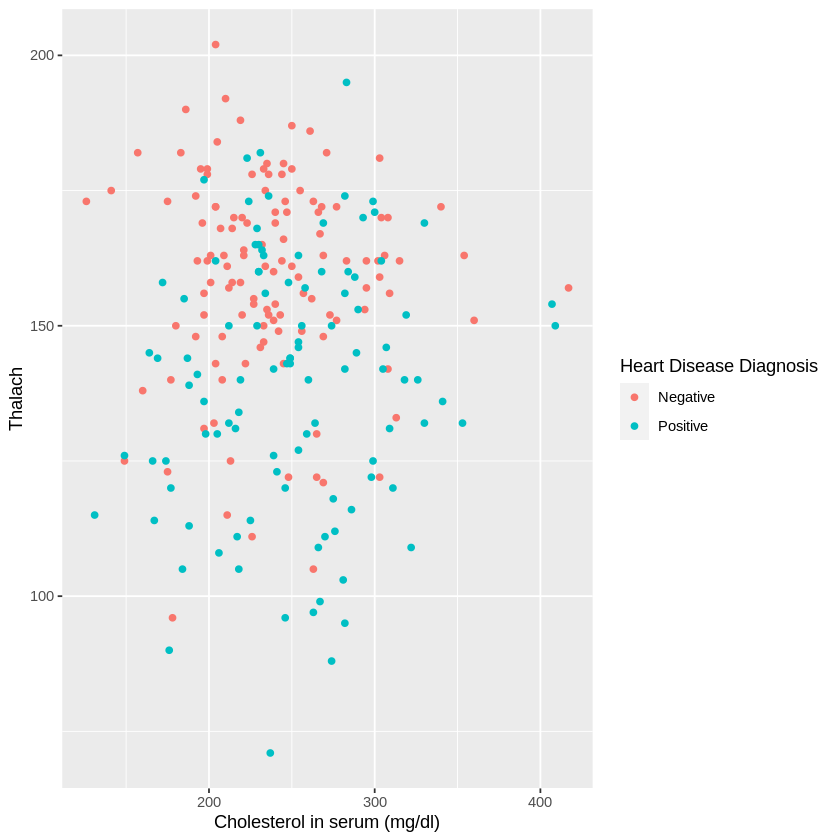

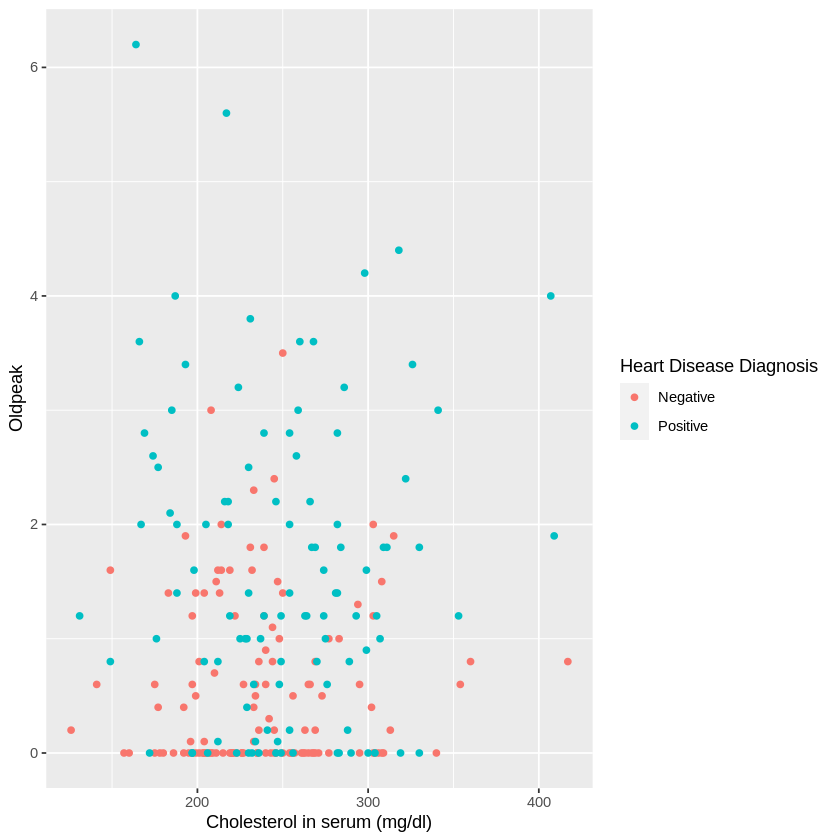

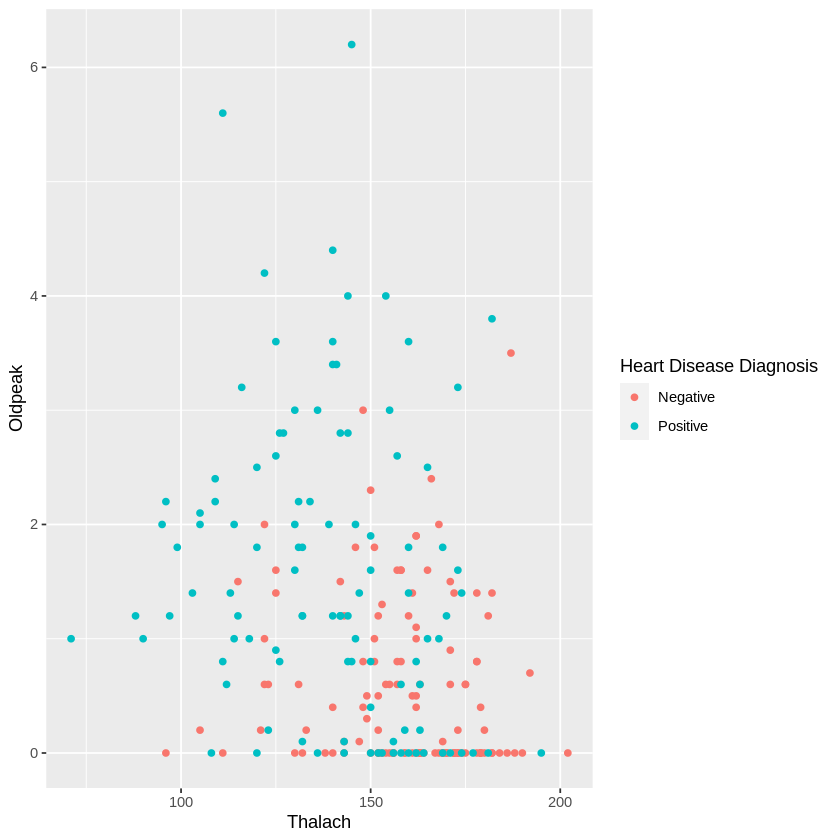

In [61]:
age_thalach_plot <- heart_train |>
    ggplot(aes(x=age, y=thalach, color= diagnosis))+
    geom_point()+
    labs(x="Age", y="Maximum Heart Rate Achieved (Thalach)", color="Heart Disease Diagnosis")
age_thalach_plot

age_chol_plot <- heart_train |>
    ggplot(aes(x=age, y=chol, color= diagnosis))+
    geom_point()+
    labs(x="Age", y="Cholesterol in serum (mg/dl)", color="Heart Disease Diagnosis")
age_chol_plot

age_oldpeak_plot <- heart_train |>
    ggplot(aes(x=age, y=oldpeak, color= diagnosis))+
    geom_point()+
    labs(x="Age", y="Oldpeak", color="Heart Disease Diagnosis")
age_oldpeak_plot

chol_thalach_plot <- heart_train |>
    ggplot(aes(x=chol, y=thalach, color= diagnosis))+
    geom_point()+
    labs(x="Cholesterol in serum (mg/dl)", y="Thalach", color="Heart Disease Diagnosis")
chol_thalach_plot

chol_oldpeak_plot <- heart_train |>
    ggplot(aes(x=chol, y=oldpeak, color= diagnosis))+
    geom_point()+
    labs(x="Cholesterol in serum (mg/dl)", y="Oldpeak", color="Heart Disease Diagnosis")
chol_oldpeak_plot

oldpeak_thalach_plot <- heart_train |>
    ggplot(aes(x=thalach, y=oldpeak, color= diagnosis))+
    geom_point()+
    labs(x="Thalach", y="Oldpeak", color="Heart Disease Diagnosis")
oldpeak_thalach_plot


### Methods

### Expected Outcomes and Significance